# Sebastián Núñez Mejía
### Matemático con Maestría en Big Data y Ciencia de Datos

---

📞 **Celular**: [3144610417](tel:+573144610417)  
✉️ **Email**: [snmsebastian@gmail.com](mailto:tu-email@dominio.com)

---

---

**Áreas de especialización:**
- **Análisis de Datos**  
- **Machine Learning y Modelado Predictivo**  
- **Optimización de Procesos ETL**  
- **Automatización y Visualización de Datos**  
- **Gestión de Bases de Datos**
- **Optimización de Decisiones Estratégicas**



#  Cargar librerias


In [1]:
import os #interactuar con el sistema operativo
import pyodbc#establecer conexiones con bases de datos usando ODBC 
from dotenv import load_dotenv #permite cargar variables de entorno desde un archivo .env
import pandas as pd #manipular y analizar datos estructurados


#  Crear el archivo .env para almacenar las credenciales


In [2]:
with open('.env', 'w') as f:
    f.write('''
DB_SERVER=20.122.25.241
DB_NAME=SkandiaBItest
DB_USER=Sebastian_Mejia
DB_PASSWORD=Skandia.123
''')
print("Archivo .env creado con éxito.")

Archivo .env creado con éxito.


#  Conexión a la base de datos

In [3]:


# Cargar variables de entorno desde el archivo .env
#hace que las variables definidas en el archivo .env estén disponibles a través de os.getenv()
load_dotenv()

def connect_to_database():
    """
    Establece una conexión a la base de datos SQL y maneja posibles errores.
    Returns:
        connection (pyodbc.Connection): Objeto de conexión si es exitoso.
        cursor (pyodbc.Cursor): Cursor abierto para ejecutar consultas.
    Raises:
        ValueError: Si ocurre un error en la conexión.
    """
    # Variables de entorno para las credenciales
    server = os.getenv("DB_SERVER")
    database = os.getenv("DB_NAME")
    username = os.getenv("DB_USER")
    password = os.getenv("DB_PASSWORD")

    if not all([server, database, username, password]):
        raise ValueError("Faltan variables de entorno. Verifica el archivo .env")

    # Configuración del tiempo de espera y cadena de conexión
    connection_string = (
    f"DRIVER={{ODBC Driver 18 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Timeout=10;"
    f"TrustServerCertificate=yes;"  # Ignorar la validación del certificado SSL
    )

    try:
        # Establecer conexión
        connection = pyodbc.connect(connection_string)
        print("Conexión exitosa a la base de datos.")
        
        # Crear un cursor que se usará para las consultas
        cursor = connection.cursor()
        return connection, cursor

    except pyodbc.InterfaceError:
        raise ValueError("No se pudo establecer una conexión. Verifica la IP o la red.")
    except pyodbc.OperationalError as e:
        if "28000" in str(e):
            raise ValueError("Credenciales incorrectas.")
        elif "08001" in str(e):
            raise ValueError("El servidor no se encontró o la IP está bloqueada.")
        elif "08S01" in str(e):
            raise ValueError("Error de red.")
        else:
            raise ValueError(f"Error operacional desconocido: {e}")
    except Exception as e:
        raise ValueError(f"Error inesperado al conectar: {e}")


## Test conexión

In [ ]:

# Probar la conexión y dejar el cursor abierto
def test_connection():
    """
    Prueba la conexión a la base de datos, mantiene el cursor abierto para consultas y garantiza un cierre seguro.
    """
    connection = None
    cursor = None
    try:
        connection, cursor = connect_to_database()
        print("Conexión y cursor abiertos correctamente.")
        
        # Aquí puedes realizar consultas utilizando el cursor.
        # Ejemplo de consulta: Obtener las tablas
        cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_type = 'BASE TABLE'")
        tables = cursor.fetchall()
        print("Tablas en la base de datos:")
        for table in tables:
            print(table[0])  # El nombre de la tabla está en la primera columna
        
    except Exception as e:
        print(f"Error al ejecutar la consulta: {e}")

# Ejecutar la prueba
test_connection()

#  Obtener tablas como df

In [4]:
def get_tables(cursor):
    """
    Obtiene los nombres de todas las tablas de la base de datos.
    Args:
        cursor (pyodbc.Cursor): El cursor de la base de datos.
    Returns:
        list: Lista con los nombres de las tablas.
    """
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_type = 'BASE TABLE'")
    tables = cursor.fetchall()
    return [table[0] for table in tables]


##  Dataframes as parquet

In [5]:

def save_table_as_parquet(cursor, table_name):
    """
    Obtiene una tabla de la base de datos, la guarda como un DataFrame y la exporta a formato Parquet.
    Args:
        cursor (pyodbc.Cursor): El cursor de la base de datos.
        table_name (str): El nombre de la tabla a consultar.
    """
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, cursor.connection)  # Leer la tabla como DataFrame

    # Guardar como archivo Parquet
    df.to_parquet(f"{table_name}.parquet", index=False)
    print(f"Tabla {table_name} guardada como archivo Parquet.")


def process_all_tables():
    """
    Obtiene todas las tablas, las guarda como archivos Parquet y realiza análisis descriptivos.
    """
    connection, cursor = connect_to_database()
    try:
        tables = get_tables(cursor)
        for table in tables:
            save_table_as_parquet(cursor, table)
    except Exception as e:
        print(f"Error en el procesamiento de tablas: {e}")

# Ejecutar el proceso
process_all_tables()

Conexión exitosa a la base de datos.


/tmp/ipykernel_587826/2594420339.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cursor.connection)  # Leer la tabla como DataFrame
/home/sebastian/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Tabla Artist guardada como archivo Parquet.
Tabla Album guardada como archivo Parquet.
Tabla Employee guardada como archivo Parquet.
Tabla Customer guardada como archivo Parquet.
Tabla Genre guardada como archivo Parquet.
Tabla Invoice guardada como archivo Parquet.
Tabla Playlist guardada como archivo Parquet.
Tabla MediaType guardada como archivo Parquet.
Tabla Track guardada como archivo Parquet.
Tabla PlaylistTrack guardada como archivo Parquet.
Tabla InvoiceLine guardada como archivo Parquet.


# Consultas

## Analisis dataframes
Se realizara un analisis de los dataframes que intervienen en la realizacion del ejercicio de consultas

In [6]:

# Realiza la consulta SQL para obtener los datos
connection, cursor = connect_to_database()

query_customer = "SELECT Country, State, City, CustomerID FROM Customer"
df_customer = pd.read_sql(query_customer, cursor.connection) 

query_invoice = "SELECT * FROM Invoice"
df_invoice = pd.read_sql(query_invoice, cursor.connection) 

query_invoiceLine = "SELECT * FROM InvoiceLine "
df_invoiceLine  = pd.read_sql(query_invoiceLine, cursor.connection) 

query_track= "SELECT * FROM Track"
df_track = pd.read_sql(query_track, cursor.connection)

query_artist="SELECT * FROM Artist"
df_artist=pd.read_sql(query_artist,cursor.connection)

query_album="SELECT * FROM Album"
df_album=pd.read_sql(query_album,cursor.connection)

query_genere = "SELECT * FROM Genre"
df_genere = pd.read_sql(query_genere, cursor.connection) 

Conexión exitosa a la base de datos.


/tmp/ipykernel_587826/1331241348.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql(query_customer, cursor.connection)
/tmp/ipykernel_587826/1331241348.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_invoice = pd.read_sql(query_invoice, cursor.connection)
/tmp/ipykernel_587826/1331241348.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_invoiceLine  = pd.read_sql(query_invoiceLine, cursor.connection)
/tmp/ipykernel_587826/1331241348.py:14: UserWarning: pandas only supports SQLAlchemy 

In [7]:
contains_none_state = df_customer['State'].isna().any()
contains_none_city = df_customer['City'].isna().any()
print(f'la columna state contiene none?:{contains_none_state}')
print(f'la columna city contiene none?:{contains_none_city}')

la columna state contiene none?:True
la columna city contiene none?:False


In [16]:

def analizar_dataframe(df):
    """
    Esta función recibe un DataFrame y devuelve tres análisis descriptivos:
    - info(): Información general sobre el DataFrame.
    - describe(): Estadísticas descriptivas para las columnas numéricas.
    - value_counts(): Conteo de frecuencias para las columnas categóricas.
    - Verifica si existen valores nulos o None en alguna de las columnas.
    
    Parámetros:
    df: DataFrame a analizar.
    
    Retorna:
    - None. Imprime los resultados en la consola.
    """
    # Información general del DataFrame
    print("\n" + "="*70 + "\n")
    print(f'{"="*10} Informacion del dataframe\n')
    print("\n" + "="*70 + "\n")

    print("Información general del DataFrame (info):")
    print(df.info())
    print("\n" + "-"*50 + "\n")
    
    # Estadísticas descriptivas para las columnas numéricas
    print("Estadísticas descriptivas para las columnas numéricas (describe):")
    print(df.describe())
    print("\n" + "-"*50 + "\n")
    
    # Conteo de frecuencias para las columnas categóricas
    print("Conteo de frecuencias para las columnas categóricas (value_counts):")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"\n{col}:")
        print(df[col].value_counts())
        print("\n" + "-"*50)
    
    # Verificación de valores nulos
    print("\n" + "-"*50 + "\n")
    print("Verificación de valores nulos (NaN o None):")
    null_columns = df.isnull().sum()
    null_columns = null_columns[null_columns > 0]
    
    if len(null_columns) > 0:
        print("Las siguientes columnas contienen valores nulos:")
        print(null_columns)
    else:
        print("No se encontraron valores nulos en ninguna columna.")


In [17]:
lst_df=[df_customer,df_invoice,df_invoiceLine,df_track,df_artist,df_album,df_genere ]

for df in lst_df:
    analizar_dataframe(df)



========== Informacion del dataframe



Información general del DataFrame (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Country     59 non-null     object
 1   State       30 non-null     object
 2   City        59 non-null     object
 3   CustomerID  59 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.0+ KB
None

--------------------------------------------------

Estadísticas descriptivas para las columnas numéricas (describe):
       CustomerID
count   59.000000
mean    30.000000
std     17.175564
min      1.000000
25%     15.500000
50%     30.000000
75%     44.500000
max     59.000000

--------------------------------------------------

Conteo de frecuencias para las columnas categóricas (value_counts):

Country:
Country
USA               13
Canada             8
Brazil             5
France             5
Germany        

## Consulta 1

De la tabla Customer realice un conteo y agrupe por estado y ciudad, y grafico con el top 5 de los países con mayor cantidad de clientes.

Dado que state presenta valores None, creamos un diccionario clave:country+city, valor:abreviatura de estado.

In [18]:
state_abbreviations = {
    'BrazilSão José dos Campos': 'SP',   # São Paulo
    'GermanyStuttgart': 'BW',             # Baden-Württemberg
    'CanadaMontréal': 'QC',               # Quebec
    'NorwayOslo': 'Oslo',                 # Oslo no tiene abreviatura, es la ciudad
    'Czech RepublicPrague': 'PR',          # Prague es la ciudad, no un estado
    'AustriaVienne': 'VIE',               # Viena (no tiene una abreviatura tradicional de estado, pero VIE es su código)
    'BelgiumBrussels': 'BRU',             # Bruselas no tiene un estado, pero BRU es su código
    'DenmarkCopenhagen': 'H',             # Hovedstaden (Región capital de Dinamarca)
    'BrazilSão Paulo': 'SP',              # São Paulo
    'BrazilRio de Janeiro': 'RJ',         # Rio de Janeiro
    'BrazilBrasília': 'DF',               # Distrito Federal
    'CanadaEdmonton': 'AB',               # Alberta
    'CanadaVancouver': 'BC',              # Columbia Británica
    'USAMountain View': 'CA',             # California
    'USARedmond': 'WA',                   # Washington
    'USANew York': 'NY',                  # Nueva York
    'USACupertino': 'CA',                 # California
    'USAReno': 'NV',                      # Nevada
    'USAOrlando': 'FL',                   # Florida
    'USABoston': 'MA',                    # Massachusetts
    'USAChicago': 'IL',                   # Illinois
    'USAMadison': 'WI',                   # Wisconsin
    'USAFort Worth': 'TX',                # Texas
    'USATucson': 'AZ',                    # Arizona
    'USASalt Lake City': 'UT',            # Utah
    'CanadaToronto': 'ON',                # Ontario
    'CanadaOttawa': 'ON',                 # Ontario
    'CanadaHalifax': 'NS',                # Nueva Escocia
    'CanadaWinnipeg': 'MB',               # Manitoba
    'CanadaYellowknife': 'NT',            # Territorios del Noroeste
    'PortugalLisbon': 'Lisbon',           # Lisboa no tiene un estado, es la ciudad capital
    'PortugalPorto': 'Porto',             # Porto es una ciudad y no un estado
    'GermanyBerlin': 'BE',                # Berlín
    'GermanyFrankfurt': 'HE',             # Hesse
    'FranceParis': 'IDF',                 # Île-de-France
    'FranceLyon': 'ARA',                  # Auvernia-Ródano-Alpes
    'FranceBordeaux': 'NAQ',              # Nueva Aquitania
    'FranceDijon': 'BFC',                 # Borgoña-Franco Condado
    'FinlandHelsinki': 'HE',              # Helsinki-Uusimaa
    'HungaryBudapest': 'BU',              # Budapest es la ciudad capital
    'IrelandDublin': 'Dublin',            # Dublín es la ciudad capital
    'ItalyRome': 'LAZ',                   # Lazio
    'NetherlandsAmsterdam': 'NH',         # Holanda Septentrional
    'PolandWarsaw': 'MAZ',                # Mazovia
    'SpainMadrid': 'MD',                  # Madrid
    'SwedenStockholm': 'AB',              # Estocolmo
    'United KingdomLondon': 'ENG',        # Inglaterra
    'United KingdomEdinburgh ': 'SCT',    # Escocia
    'AustraliaSidney': 'NSW',             # Nueva Gales del Sur
    'ArgentinaBuenos Aires': 'BA',        # Buenos Aires
    'ChileSantiago': 'RM',                # Región Metropolitana
    'IndiaDelhi': 'DL',                   # Delhi
    'IndiaBangalore': 'KA'                # Karnataka
}


In [19]:
# Función para asignar el estado usando el diccionario
def assign_state(row):
    # Concatenar la combinación de país y ciudad
    country_city = row['Country'] + row['City']
    # Buscar el estado en el diccionario
    return state_abbreviations.get(country_city, 'Unknown')  # Si no se encuentra, devolver 'Unknown'

# Asignar la columna 'State' al DataFrame usando la función
df_customer['State2'] = df_customer.apply(assign_state, axis=1)


In [20]:
df_customer['State2'].unique()

array(['SP', 'BW', 'QC', 'Oslo', 'PR', 'VIE', 'BRU', 'H', 'RJ', 'DF',
       'AB', 'BC', 'CA', 'WA', 'NY', 'NV', 'FL', 'MA', 'IL', 'WI', 'TX',
       'AZ', 'UT', 'ON', 'NS', 'MB', 'NT', 'Lisbon', 'Porto', 'BE', 'HE',
       'IDF', 'ARA', 'NAQ', 'BFC', 'BU', 'Dublin', 'LAZ', 'NH', 'MAZ',
       'MD', 'ENG', 'SCT', 'NSW', 'BA', 'RM', 'DL', 'KA'], dtype=object)

In [21]:
 # Leer la tabla como DataFrame

# Agrupar por Estado y Ciudad, y contar los clientes
df_grouped = df_customer.groupby(['State2', 'City']).agg(client_count=('CustomerID', 'count'))
df_grouped=df_grouped.sort_values(by=(['client_count','State2','City']),ascending=[False,True,True]).reset_index()

# Mostrar los primeros 10 registros del DataFrame agrupado
print('------------------------------------------\n')
print('Numero de clientes por estado y ciudad\n')
print('------------------------------------------\n')
print(df_grouped)

------------------------------------------

Numero de clientes por estado y ciudad

------------------------------------------

    State2                 City  client_count
0       BE               Berlin             2
1       CA        Mountain View             2
2      ENG               London             2
3      IDF                Paris             2
4       PR               Prague             2
5       SP            São Paulo             2
6       AB             Edmonton             1
7       AB            Stockholm             1
8      ARA                 Lyon             1
9       AZ               Tucson             1
10      BA         Buenos Aires             1
11      BC            Vancouver             1
12     BFC                Dijon             1
13     BRU             Brussels             1
14      BU             Budapest             1
15      BW            Stuttgart             1
16      CA            Cupertino             1
17      DF             Brasília             

### Grafico
top 5 de los países con mayor cantidad de clientes.

In [22]:
# Agrupar por pais, y contar los clientes
df_grouped_by_country = df_customer.groupby('Country').agg(client_count=('CustomerID', 'count'))
df_grouped_by_country_sorted = df_grouped_by_country.sort_values(by='client_count', ascending=False).reset_index()
df_grouped_by_country_top5 = df_grouped_by_country_sorted.head(5)
print('-------------------------------------------------------\n')
print('top 5 de los países con mayor cantidad de clientes\n')
print('-------------------------------------------------------\n')
print(df_grouped_by_country_top5)


-------------------------------------------------------

top 5 de los países con mayor cantidad de clientes

-------------------------------------------------------

   Country  client_count
0      USA            13
1   Canada             8
2   Brazil             5
3   France             5
4  Germany             4


Se nota un claro numero mayor de clientes en USA, y ya que entre USA y Canada se llevan el 60% del top 5, se espera que el top 5 de artistas este igualmente dominado por artistas de habla inglesa

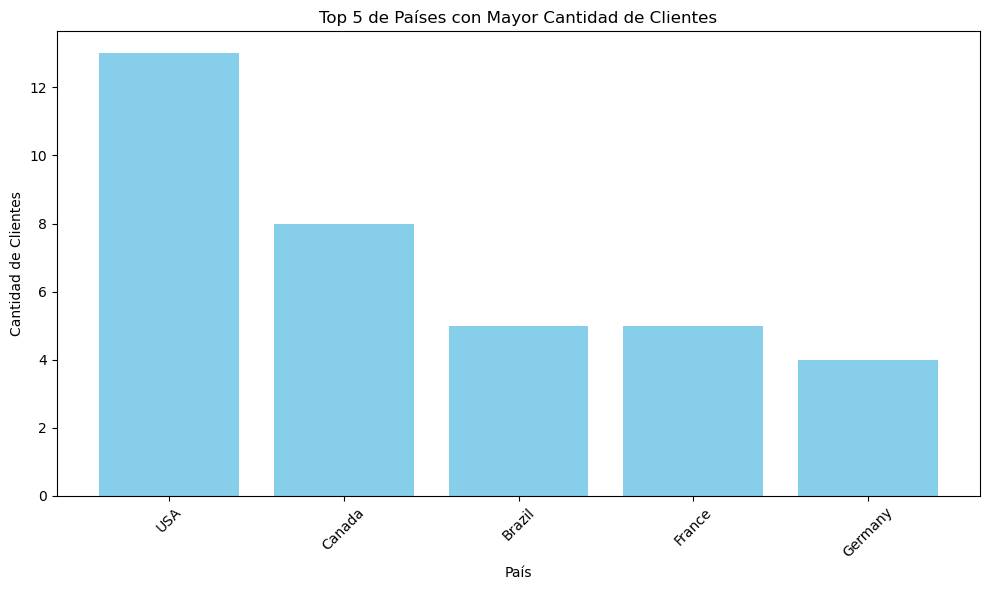

In [23]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras para mostrar el top 5 de países con más clientes
plt.figure(figsize=(10, 6))
plt.bar(df_grouped_by_country_top5['Country'], df_grouped_by_country_top5['client_count'], color='skyblue')

# Etiquetas y título
plt.xlabel('País')
plt.ylabel('Cantidad de Clientes')
plt.title('Top 5 de Países con Mayor Cantidad de Clientes')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor visualización

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Consulta 2

De las tablas Invoice y InvoiceLine realice un análisis donde indique:
1 cuales son los 5 tracks más vendidos,
2 los 5 artistas que más venden,
3 el mes donde más ventas se tienen 
4 realice una gráfica con los 5 géneros más vendidos.

Inicialmente se obtiene la informacion de cada track que aparece facturado

In [24]:

#Top track por unidades vendidas
info_track=pd.merge(df_invoiceLine,
                   df_track[['TrackId','Name','AlbumId','GenreId']],
                   on='TrackId',
                   how='inner')
info_track=pd.merge(info_track,
                    df_album,
                    on='AlbumId',
                    how='inner')
info_track=pd.merge(info_track,
                    df_artist,
                    on='ArtistId',
                    how='inner')
info_track=pd.merge(info_track,
                    df_genere,
                    on='GenreId',
                    how='inner')
info_track=info_track.rename(columns={ 'Name_x':'Name track',
  'Title':'Name album', 
 'Name_y':'Name artist', 
 'Name':'Name genere'})
info_track.head()
info_track=info_track[['InvoiceLineId', 'InvoiceId',  'UnitPrice', 'Quantity','TrackId', 'Name track', 'AlbumId','Name album', 'GenreId','Name genere',  'ArtistId',
       'Name artist' ]]
info_track.head()

,InvoiceLineId,InvoiceId,UnitPrice,Quantity,TrackId,Name track,AlbumId,Name album,GenreId,Name genere,ArtistId,Name artist
0,1,1,0.99,1,2,Balls to the Wall,2,Balls to the Wall,1,Rock,2,Accept
1,1154,214,0.99,1,2,Balls to the Wall,2,Balls to the Wall,1,Rock,2,Accept
2,2,1,0.99,1,4,Restless and Wild,3,Restless and Wild,1,Rock,2,Accept
3,580,108,0.99,1,5,Princess of the Dawn,3,Restless and Wild,1,Rock,2,Accept
4,1728,319,0.99,1,3,Fast As a Shark,3,Restless and Wild,1,Rock,2,Accept


In [25]:
# Agrupar por 'Name track' y obtener una lista de los diferentes 'TrackId'
track_details = info_track.groupby('Name track').agg(
    Track_Count=('TrackId', 'count'),         # Contar las ocurrencias
    Track_Ids=('TrackId', lambda x: list(x)) # Crear lista de 'TrackId'
).reset_index()

# Ordenar por el conteo en orden descendente
track_details = track_details.sort_values(by='Track_Count', ascending=False)

# Mostrar los resultados
print("Resumen detallado por pista:")
print(track_details)

# Mostrar los valores únicos del conteo
unique_track_counts = track_details['Track_Count'].unique()
print("\nValores únicos del conteo por pista:")
print(unique_track_counts)



Resumen detallado por pista:
                        Name track  Track_Count  \
1644                   The Trooper            5   
1739                      Untitled            4   
1509           Sure Know Something            4   
653           Hallowed Be Thy Name            4   
485                       Eruption            4   
...                            ...          ...   
676                  Help Yourself            1   
675   Hell Ain't A Bad Place To Be            1   
674                     Heliopolis            1   
673              Heavy Love Affair            1   
1887                        Óculos            1   

                           Track_Ids  
1644  [1322, 1322, 1213, 1290, 1339]  
1739        [2154, 2154, 2295, 2295]  
1509          [439, 439, 1567, 1567]  
653         [1321, 1321, 1368, 1390]  
485         [3064, 3064, 3082, 3082]  
...                              ...  
676                           [3476]  
675                             [21]  
674    

Dado que existen tracks con diferente id, el top 5 de track se hara no por id si no por name track

In [26]:
tracks_count=info_track['Name track'].value_counts(ascending=False)
# Convertir a DataFrame y asignar un nombre a la columna
tracks = tracks_count.reset_index()
tracks.columns = ['Name track', 'num tracks sales']

In [27]:
tracks

,Name track,num tracks sales
0,The Trooper,5
1,Sure Know Something,4
2,Eruption,4
3,Untitled,4
4,Hallowed Be Thy Name,4
...,...,...
1883,Dirty Water Dog,1
1884,Primary,1
1885,Neworld,1
1886,One I Want,1


### Top 5 tracks más vendidos

In [28]:
info_track_unique = info_track[['Name track', 'UnitPrice']].drop_duplicates()
tracks_sales=pd.merge(tracks,
                      info_track_unique,
                      on='Name track',
                      how='inner')
tracks_sales['total sales']=tracks_sales['UnitPrice']*tracks_sales['num tracks sales']
# Mostrar el resultado}
print('------------------------------------------------------------\n')
print('Top  5 tracks con mas ventas ')
print('------------------------------------------------------------\n')
print(tracks_sales.head(5))


------------------------------------------------------------

Top  5 tracks con mas ventas 
------------------------------------------------------------

             Name track  num tracks sales  UnitPrice  total sales
0           The Trooper                 5       0.99         4.95
1   Sure Know Something                 4       0.99         3.96
2              Eruption                 4       0.99         3.96
3              Untitled                 4       0.99         3.96
4  Hallowed Be Thy Name                 4       0.99         3.96


Como se esperaba el top 5 de track son de habla inglesa

Ademas este resultado como era de esperarse nos  indica que el precio del track es una variable de importancia al momento de posicionar la venta del track en el top

###  Top 5 artistas que más venden

In [29]:
artist=pd.merge(tracks_sales,
                info_track[['Name track','Name artist']],
                on='Name track',
                how='inner')

artist_top=artist.groupby(by=['Name artist'])['total sales'].sum().reset_index()
artist_top=artist_top.sort_values(by=['total sales'],ascending=[False])
# Mostrar el resultado}
print('------------------------------------------------------------\n')
print('Top  5 artistas con mas ventas ')
print('------------------------------------------------------------\n')
print(artist_top.head(5))

------------------------------------------------------------

Top  5 artistas con mas ventas 
------------------------------------------------------------

      Name artist  total sales
69    Iron Maiden       264.33
156            U2       155.43
82   Led Zeppelin       136.62
95      Metallica       120.78
85           Lost        85.57


Como nos viene indicando la informacion, el top 5 esta totalmente dominado por el habla inglesa

### Top mes donde más ventas se tienen 

In [30]:
# Verificar si hay valores None o NaN en la columna 'Total'
contains_none = df_invoice['InvoiceDate'].isna().any()

# Imprimir el resultado
if contains_none:
    print("La columna 'InvoiceDate' contiene valores None o NaN.")
else:
    print("La columna 'InvoiceDate' no contiene valores None o NaN.")

La columna 'InvoiceDate' no contiene valores None o NaN.


In [35]:
# Agrupar por 'TrackId' y contar cuántas veces se repite cada uno

df_invoice['month']=df_invoice['InvoiceDate'].dt.month
month_top = df_invoice.groupby('month')['Total'].sum().reset_index(name='Total_sales')
month_top=month_top.sort_values(by='Total_sales',ascending=[False])
# Mostrar el resultado}
print('------------------------------------------------------------\n')
print('Top  5 meses con mas ventas ')
print('------------------------------------------------------------\n')
print(f'los 5 meses con mayores ventas son')
print(month_top.head(12))

------------------------------------------------------------

Top  5 meses con mas ventas 
------------------------------------------------------------

los 5 meses con mayores ventas son
    month  Total_sales
0       1       201.12
5       6       201.10
3       4       198.14
7       8       198.10
8       9       196.20
2       3       195.10
4       5       193.10
9      10       193.10
6       7       190.10
11     12       189.10
1       2       187.20
10     11       186.24


El hecho de que no haya discrepancia abrupta entre los meses, nos indica que no hay un mes que sea categoricamente mas adecuado para el lanzamiento de un disco, lo cuál es positivo pues indica que el negocio de la musica presenta una tendencia no negativa de ventas durante el año.

### Top 5 géneros más vendidos

In [32]:
genere=pd.merge(tracks_sales,
                info_track[['Name track','Name genere']],
                      on='Name track',
                      how='inner')
genere_top=genere.groupby(by='Name genere')['total sales'].sum().reset_index()
genere_top=genere_top.sort_values(by=['total sales','Name genere'],ascending=[False,True])
print('------------------------------------------------------------\n')
print('Top  5 generos con mas ventas ')
print('------------------------------------------------------------\n')
print(genere_top.head(5))

------------------------------------------------------------

Top  5 generos con mas ventas 
------------------------------------------------------------

           Name genere  total sales
17                Rock      1147.41
12               Latin       497.97
13               Metal       389.07
1   Alternative & Punk       335.61
22            TV Shows       111.44


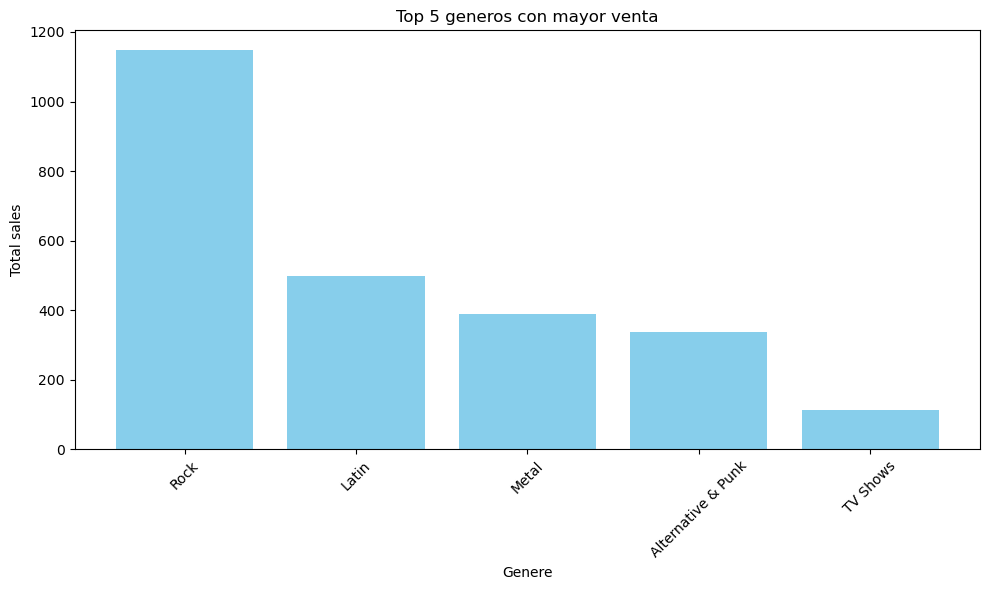

In [33]:

# Crear un gráfico de barras para mostrar el top 5 de países con más clientes
plt.figure(figsize=(10, 6))
plt.bar(genere_top['Name genere'].head(5), genere_top['total sales'].head(5), color='skyblue')

# Etiquetas y título
plt.xlabel('Genere')
plt.ylabel('Total sales')
plt.title('Top 5 generos con mayor venta')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor visualización

# Mostrar el gráfico
plt.tight_layout()
plt.show()